In [1]:
import os
from scTrace.pipeline import *

E:\Software\Anaconda\installation\envs\scTrace_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Run scTrace+ on TraCe-seq

#### Load data: [TraCe-seq-tumor](https://cloud.tsinghua.edu.cn/f/dae5b3ff8bd04177bd5f/?dl=1)

In [2]:
dataSet = "NBT21-TraceSeq"
samName = "CellLines"
run_label = dataSet + "_" + samName

dataPath = "D:/Lineage-data/NBT21-TraceSeq/NBT21-TraCeseq-example/"

data_0 = sc.read(dataPath + 'D0_scobj.h5ad')
data_4 = sc.read(dataPath + 'D4_erlo_scobj.h5ad')

In [3]:
data_4.obs["gfpbc"].value_counts()

gfpbc
GFPBC_libB_89090                     388
GFPBC_libB_80333                     186
GFPBC_libB_43724                     167
GFPBC_libB_90011                     151
GFPBC_libB_93654                     144
                                    ... 
GFPBC_libB_37672|GFPBC_libB_90348      1
GFPBC_libB_36776                       1
GFPBC_libB_35218|GFPBC_libB_89090      1
GFPBC_libB_35218|GFPBC_libB_58191      1
No_BC                                  0
Name: count, Length: 550, dtype: int64

In [4]:
savePath = "D:/Lineage-data/NBT21-TraceSeq/Results/" # + run_label + "/"

if not os.path.exists(savePath):
    os.makedirs(savePath)

colors = [['#B5A2E0', '#F9B475', '#50C7CA', '#CF747A', '#63AFF0', '#8792AF', '#E0CB00', '#DC7EC0'],
          ["#43D9FE", "#E78AC3", "#FEC643", "#A6D854", "#FE6943", "#E5C494", "#33AEB1", "#FFEC1A", "#4878D0", '#984EA3', 
           '#CF747A', '#4DAF4A', '#C2C2C2']]

In [5]:
all_data = [data_0, data_4]
print(data_0.shape)
print(data_4.shape)
all_names = ['Day0', 'Day4']

(20675, 4212)
(5323, 4212)


#### Only 2 time points in demo, set time = 0

In [6]:
time = 0

In [7]:
data_pre, data_pos = all_data[time:(time+2)]
pre_name, pos_name = all_names[time:(time+2)]

pre_colors = colors[time]
pos_colors = colors[time+1]

n_pre = data_pre.shape[0]
n_pos = data_pos.shape[0]
run_label_time = run_label + '-' + pre_name + '_' + pos_name
print(run_label_time)

NBT21-TraceSeq_CellLines-Day0_Day4


#### `prepareCrosstimeGraph`: Process input time-series dataset, output lineage adjacency matrices and transcriptome similarity matrices, both within and across timepoints.
#### `lineage_identity` refers to the name of columns containing lineage information in "obs" of scanpy object.

Number of cells in the former time point:  20675
Number of cells with flow-out information:  15580
Flow-out density:  0.7535671100362757
Number of cells in the latter time point:  5323
Number of cells with flow-in information:  4963
Flow-in density:  0.9323689648694345
Generating mother-daughter similarity
0.6637773255235399 0.6811559004893432


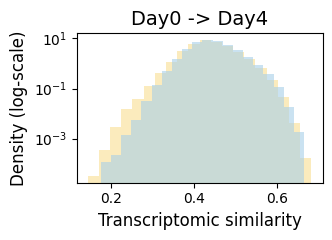

In [9]:
cross_sp_df, cross_lin_mat, barcodes_pre, barcodes_pos = prepareCrosstimeGraph(data_pre=data_pre, data_pos=data_pos,
                                                                               lineage_identity='gfpbc',
                                                                               pre_name=pre_name, pos_name=pos_name,
                                                                               savePath=savePath, run_label_time=run_label_time)

#### `prepareWithintimeGraph`: Optional, for visualization only

Generating mother-daughter similarity (with-in timepoint)
0.7123040537985919 0.7131854725888808


0

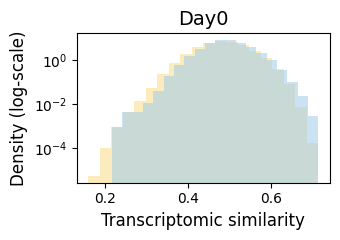

In [8]:
sim, within_lin_mat = prepareWithintimeGraph(data_pre=data_pre,data_pos=data_pos,
                                             lineage_identity='gfpbc',
                                             pre_name=pre_name, pos_name=pos_name,
                                             savePath=savePath, run_label_time=run_label_time,
                                             mode='pre')
del(sim, within_lin_mat)
gc.collect()

Generating mother-daughter similarity (with-in timepoint)
0.731195998236711 0.7319768112165328


0

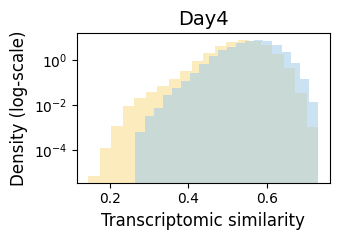

In [9]:
sim, within_lin_mat = prepareWithintimeGraph(data_pre=data_pre,data_pos=data_pos,
                                             lineage_identity='gfpbc',
                                             pre_name=pre_name, pos_name=pos_name,
                                             savePath=savePath, run_label_time=run_label_time,
                                             mode='pos')
del(sim, within_lin_mat)
gc.collect()

#### `prepareSideInformation`:  Derive low-dimensional side information matrix (Ku, Kv) with `node2vec` and `rbf kernel` (run only-once)，

In [ ]:
prepareSideInformation(data_pre=data_pre, data_pos=data_pos,
                       barcodes_pre=barcodes_pre, barcodes_pos=barcodes_pos,
                       savePath=savePath,
                       run_label_time=run_label_time,
                       single_inte_fraction=0.25)

#### Split training-validation sets for performance evaluation

In [10]:
train_df, val_df = train_valid_split(cross_sp_df, ratio=0.5, type="stratified")

Splitting train-validation set


#### `trainMF`: Train scLTMF model to predict the missing entries in the original across-timepoint transition matrix.

Loading side information
Performing matrix factorization
0.0001
trying learning rate : 0.01, regularization : 0.0001
Preprocessing data...
Preparing pre_cell side information
Preparing post_cell side information
initalizing parameters for scTrace
Epoch 1/100  | train_rmse: 0.448 - val_rmse: 0.450 - train_recall: 0.000 - val_recall: 0.000 - train_corr: 0.002 - val_corr: 0.005 - took 82.4 sec
Epoch 2/100  | train_rmse: 0.446 - val_rmse: 0.449 - train_recall: 0.000 - val_recall: 0.000 - train_corr: 0.006 - val_corr: 0.005 - took 93.9 sec
Epoch 3/100  | train_rmse: 0.443 - val_rmse: 0.449 - train_recall: 0.000 - val_recall: 0.000 - train_corr: 0.012 - val_corr: 0.006 - took 94.3 sec
Epoch 4/100  | train_rmse: 0.440 - val_rmse: 0.447 - train_recall: 0.000 - val_recall: 0.000 - train_corr: 0.018 - val_corr: 0.007 - took 63.7 sec
Epoch 5/100  | train_rmse: 0.436 - val_rmse: 0.444 - train_recall: 0.000 - val_recall: 0.000 - train_corr: 0.026 - val_corr: 0.010 - took 44.3 sec
Epoch 6/100  | tra

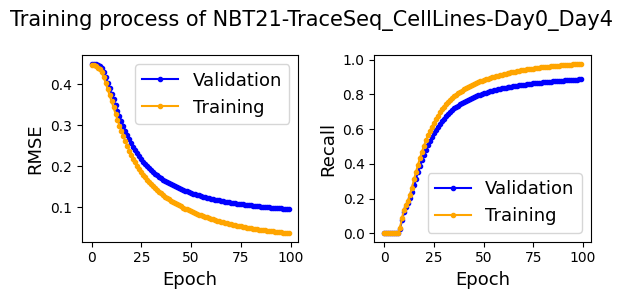

In [22]:
hyper_dict, model = trainMF(train_df=train_df,
                            val_df=val_df,
                            n_pre=n_pre, n_pos=n_pos,
                            savePath=savePath,
                            run_label_time=run_label_time,
                            n_factor=20,
                            n_epoch=100,
                            bool_pre_side=True, bool_post_side=True,
                            learning_rate=0.01, regularization=0.0001)

#### `predictMissingEntries`: Load pretrained scLTMF model and calculate performance evaluation indicators.
#### Here we set a threshold manually. You can also set the cut-off according to data distribution, see below.

Loading pretrained model...


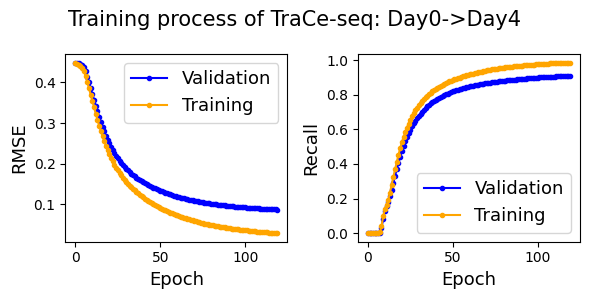

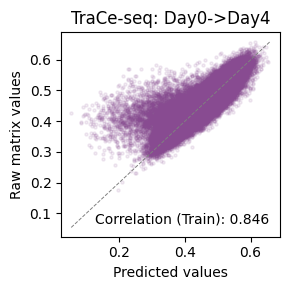

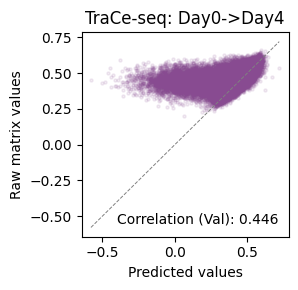

In [10]:
pred_mat, y_true, y_pred, complet_mat, corr, min_rmse, max_recall = predictMissingEntries(pre_name=pre_name,
                                                                                          pos_name=pos_name,
                                                                                          savePath=savePath,
                                                                                          run_label_time=run_label_time,
                                                                                          showName="TraCe-seq")

#### Training on full dataset for downstream analysis

In [ ]:
hyper_dict, model = trainMF(train_df=cross_sp_df,
                            val_df=cross_sp_df,
                            n_pre=n_pre, n_pos=n_pos,
                            savePath=savePath,
                            run_label_time=run_label_time,
                            n_factor=20,
                            n_epoch=100,
                            bool_pre_side=True, bool_post_side=True,
                            learning_rate=0.01, regularization=0.0001)

#### Load full model for downstream analysis

In [12]:
# Please move/rename the model or modify the following path
model = load_model(savePath + "model/" + run_label_time + '_model_full.pkl')
complet_mat = np.dot(model.p, model.q.T)

#### Automatically set the cut-off according to data distribution

In [13]:
basic_values = complet_mat.reshape((1, -1))[0][cross_lin_mat.reshape((1, -1))[0] > 0]
Q1, Q3 = np.percentile(basic_values, 25), np.percentile(basic_values, 75)
threshold = Q1 - 1.5 * (Q3 - Q1)
print(threshold)
complet_mat[complet_mat < threshold] = 0

0.31626933602836244


#### `prepareScdobj`: Prepare `scStateDynamics` objects and perform clustering method.


## 1. Identify cell clusters and cell states ---------------------------


E:\Software\Anaconda\installation\envs\scTrace_env\lib\site-packages\scStateDynamics\scStateDynamics.py:37: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(scobj, key_added='cluster', resolution=cls_res)


| - N_cells: [20675, 5323]
| - N_clusters: [5 5]
| - N_cliques: [1396  629]
| - Saving figure: D:/Lineage-data/NBT21-TraceSeq/Results/NBT21-TraceSeq_CellLines-Day0_Day4_Cell-PairUMAP.png


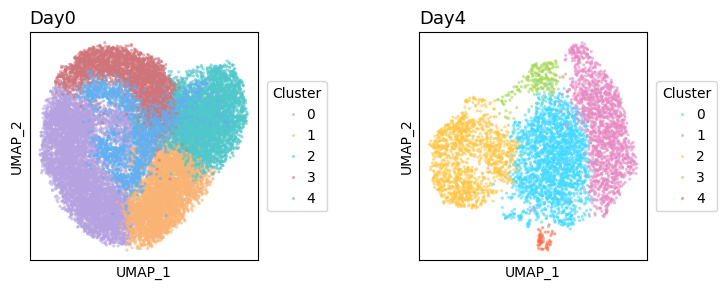

In [14]:
cls_res_all = [0.3, 0.2]
clq_res_all = [50, 50]

scd_obj = prepareScdobj(data_pre=data_pre, data_pos=data_pos,
                        time=time,
                        pre_name=pre_name, pos_name=pos_name,
                        cls_res_all=cls_res_all, clq_res_all=clq_res_all,
                        pre_colors=pre_colors, pos_colors=pos_colors,
                        savePath=savePath, run_label_time=run_label_time)

#### `visualizeLineageInfo` & `visualizeEnhancedLineageInfo`: Visualize cluster alignment results with Sankey plot. 

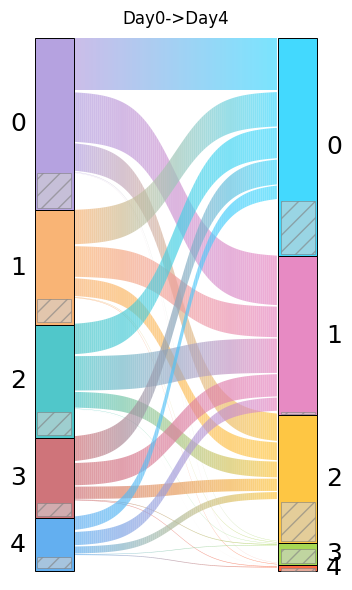

In [15]:
cls_lineage_mat, flow_info = visualizeLineageInfo(scd_obj=scd_obj,
                                                  cross_lin_mat=cross_lin_mat,
                                                  n_pre=n_pre, 
                                                  pre_colors=pre_colors, pos_colors=pos_colors,
                                                  pre_name=pre_name, pos_name=pos_name,
                                                  savePath=savePath,
                                                  run_label_time=run_label_time)

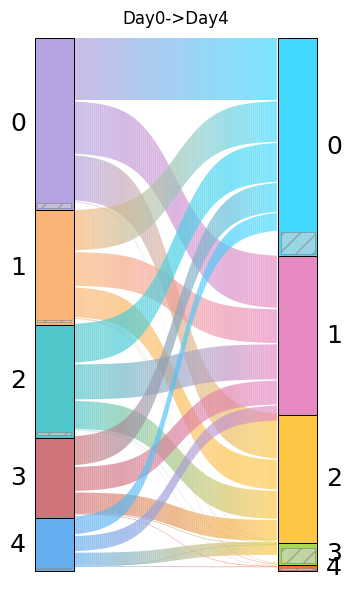

In [16]:
cls_trans_mat, flow_info_enhanced = visualizeEnhancedLineageInfo(scd_obj=scd_obj,
                                                                 complet_mat=complet_mat,
                                                                 n_pre=n_pre, 
                                                                 pre_colors=pre_colors, pos_colors=pos_colors,
                                                                 pre_name=pre_name, pos_name=pos_name,
                                                                 savePath=savePath,
                                                                 run_label_time=run_label_time)

#### `assignLineageInfo`: Assign fate information at single-cell level and output a `cell2cluster` matrix according to lineage information.

In [17]:
scd_obj = assignLineageInfo(scd_obj,
                            cross_lin_mat,
                            savePath,
                            run_label_time,
                            sel_cluster_name="cluster")

#### `enhanceFate`: Enhance cell fate information based on hypothesis testing method for single-cell level fate inference.

In [18]:
adata_pre, enhance_rate = enhanceFate(scd_obj,
                                      complet_mat,
                                      savePath,
                                      run_label_time,
                                      cluster_name='cluster')

100%|██████████| 20675/20675 [00:14<00:00, 1453.40it/s]
E:\Lineage\Code\scTrace\scTrace\pipeline.py:266: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if adata_pre.obs[enhanced_fate_colname][i] == "Missing":
E:\Lineage\Code\scTrace\scTrace\pipeline.py:268: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = val

Ratio of newly added fate clusters: 0.2506


#### Run DEGs (before and after enhancement)

#### `runFateDE`: Perform differential expression analysis between selected dynamic sub-clusters.

In [19]:
sel_cls = '2'
sel_fates = [ '2 -> 0', '2 -> 1', '2 -> 2']
cls_colname, fate_colname = 'cluster', 'Lineage_fate_label'
lt_sub_expr, lt_de = runFateDE(adata_pre, fate_colname, sel_cls, sel_fates, 
                               saveName = savePath + run_label_time + '_DE_fate_genes-' + sel_cls + '_' + fate_colname.split('_')[0] + '.txt')
cls_colname, fate_colname = 'cluster', 'Enhanced_fate_label'
eh_sub_expr, eh_de = runFateDE(adata_pre, fate_colname, sel_cls, sel_fates, 
                            saveName = savePath + run_label_time + '_DE_fate_genes-' + sel_cls + '_' + fate_colname.split('_')[0] + '.txt')

#### `dynamicDiffAnalysis`: Perform differential expression analysis between all dynamic sub-clusters. (1 v.s. rest)

In [20]:
all_de_df_lt = dynamicDiffAnalysis(scd_obj, savePath, run_label_time,
                                   sel_cluster_name="cluster",
                                   fate_colname='Lineage_fate',
                                   special_case="Missing")
all_de_df_enhanced = dynamicDiffAnalysis(scd_obj, savePath, run_label_time,
                                         sel_cluster_name="cluster",
                                         fate_colname='Enhanced_fate',
                                         special_case="Uncertain")

#### Save results

In [21]:
pre_df = adata_pre.obs[['cluster', 'Lineage_fate', 'Lineage_fate_label', 'Enhanced_fate', 'Enhanced_fate_label']]
pre_df.to_csv(savePath + run_label_time + ' - res_anno.txt', sep = '\t')